# Training Deep Neural Networks on a GPU with PyTorch
## Preparing the Data

In [the previous tutorial](https://jovian.ai/aakashns/03-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. In this post, we'll try to improve upon it  using a *feed-forward neural network* which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

# Preparing the data

The data preperation is identical to the logistic regression problem. We begin by importing the modules & classes!

In [ ]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

We download the data and create Pytorch dataset using MNIST class from `torchvision.datasets`

In [ ]:
dataset = MNIST(root = '/data', download = True, transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



Next, we define and use a function split_indices to pick a random 20% fraction of the images for the validation set.

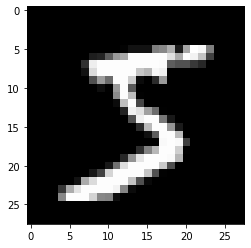

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img, label = dataset[0]
plt.imshow(img[0], cmap = 'gray')
#pyplot expects image in the form of matrix or the channel to be at the end.
#img is having the dimension[1, 28, 28]
#img[0] is removing the first channel dimension to make it a matrix

In [ ]:
def split_indices(n, val_pct):
  # Determine size of validation set
  n_val = int(val_pct * n)
  # Create random permutaiton of 0 to n-1
  idxs = np.random.permutation(n)
  # Pick first n_val indices for validation set
  return idxs[n_val:], idxs[:n_val]

In [ ]:
train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2)
print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])


48000 12000
Sample val indices:  [49515 58391 56614 13485 31657 17004 19824 54695 16778 47188 43062 32790
 36353 41825 12932 52478 51621 53475 28224 27864]


We can now create PyTorch data loaders for each of the subsets using a `SubsetRandomSampler`, which samples
elements randomly from a given list of indices, while creating batches of data.

The dataloader takes the data assigned for training (80% of 60k is 48k images) and creates batches out of it. Also it gives those batches as for loop which can use efficiently to train.


In [ ]:
batch_size = 100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler = train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler = valid_sampler)

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network.

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">



Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and no-linear relationships between the inputs and the targets.

The activation function we'll use here is called a Rectified Linear Unit or ReLU, and it has a really simple formula: `relu(x) = max(0, x)`, i.e. if anelement is negative, we replace it by 0, otherwise we leave it unchanged.


Let's define the model by extending the `nn.Module` class from PyTorch.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
for xb, yb in train_dl:
  xb = xb.view(xb.size(0), -1)
  #xb.size(0)= takes the batch size
  #-1= pytorch automatically calculate 28*28 or the size of the image
  print(xb.shape)
  break

torch.Size([100, 784])


In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

We'll create a model that contains a hidden layer with 32 activations.

In [ ]:
input_size = 784
num_classes = 10
model = MnistModel(input_size, hidden_size = 32, out_size = num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [ ]:
for t in model.parameters():
  print(t.shape)
  # internally pytorch stores matrix in a transposed format (so, 784 * 32 will be 32 *784)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 100 images from out dataset, and pass them into our model.

In [ ]:
for images, labels in train_dl:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break
print('output.shape :', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3272035121917725
output.shape : torch.Size([100, 10])
Sample outputs :
 tensor([[ 0.0825, -0.0235,  0.0394, -0.1192, -0.0244,  0.1173,  0.0830, -0.0296,
         -0.3155,  0.3527],
        [-0.0359, -0.0861,  0.0114, -0.0794, -0.0579,  0.0334,  0.0394, -0.0141,
         -0.2383,  0.2593]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [ ]:
torch.cuda.is_available()

True

Let's define a helper functin to ensure that our code uses the GPU of available, and defaults to using the CPU if it isn't.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device

In [ ]:
def to_device(data, device):
  """ Move tensor(s) to choosen device """
  if isinstance(data, (list, tuple)):
    return[to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [ ]:
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)# frist batch of data is being loaded to GPU
  break

torch.Size([100, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [ ]:
class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device """
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device """
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches """
    return len(self.dl)

We can now wrap our data loaders using DeviceDataLoader.

In [ ]:
from torch.types import Device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Tensors that have been moved to the GPU's RAM have a device property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl.`

In [ ]:
for xb, yb in valid_dl:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

xb.device: cuda:0
yb: tensor([4, 0, 1, 4, 2, 7, 3, 9, 9, 8, 2, 0, 4, 2, 0, 6, 6, 9, 0, 6, 3, 2, 2, 2,
        7, 0, 1, 1, 0, 4, 2, 5, 7, 2, 2, 7, 8, 4, 6, 7, 7, 8, 6, 4, 9, 5, 0, 8,
        7, 7, 6, 5, 2, 4, 1, 7, 9, 3, 1, 6, 8, 5, 9, 1, 2, 4, 9, 2, 1, 5, 6, 9,
        8, 2, 3, 0, 6, 7, 5, 4, 7, 7, 2, 1, 1, 1, 3, 3, 6, 2, 0, 7, 1, 3, 9, 1,
        1, 4, 6, 8], device='cuda:0')


# Training the model

As with logistic regression, we can use cross entropy as the loss function anad accuracy as the evaluation metric for our model. The training loop is identical, so we can reuse the `loss_batch`, evaluate and `fit` functions from the previous tutorial.

The `loss_batch` function calculates the loss and metric value for a batch of data, and optionally performs gradient descent if an optimizer is provided.

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):

  # Generate predictions
  preds = model(xb)
  # Calculate loss
  loss = loss_func(preds, yb)

  if opt is not None:

    # Compute gradients
    loss.backward()
    # Update parameters
    opt.step()
    # Reset gradients
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    # Compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

The `evaluate` function claculates the overall loss(and a metric, of provided) for the vlaidation set.

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric = None):
  with torch.no_grad():
    # Pass each batch through the model
    results = [loss_batch(model, loss_fn, xb, yb, metric = metric) for xb, yb in valid_dl]

    # Seperate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    # Total size of the dataset
    total = np.sum(nums)
    # Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses, nums)) / total
    avg_metric = None
    if metric is not None:
      # Avg. of metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

The `fit` function contains the actual training loop, as defined in the previous tutorials. We'll make a coupke more enhancement to the `fit` function:


1. Instead of defining optimizer manually, we'll pass in the learning rate and create an optimizer inside the `fit` function. This will allow us to train the model with different learning rates, if required.
2. We'll record the validaiton loss and accuracy at the end of every epoch, and return the history as the output of the `fit` funciton.



In [ ]:

def fit(epochs, lr, model, loss_fn, train_dl, val_dl, metric = None, opt_func = None):
    """Train the model using gradient descent"""
    losses, metrices = [], []

    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.otpim.SGD
    opt = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epochs):
        # Training Phase
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # Record the loss & metric
        losses.append(val_loss)
        metrices.append(val_metric)

        # Print progress
        if metric is None:
          print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
          print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

    return losses, metrices